In [1]:
%%bash
#pip install https://github.com/hadim/anamic/archive/f35713231804e0a35fec3c92f894a36ec8009453.zip

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import json

import anamic

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tifffile
from scipy import ndimage

ModuleNotFoundError: No module named 'anamic'

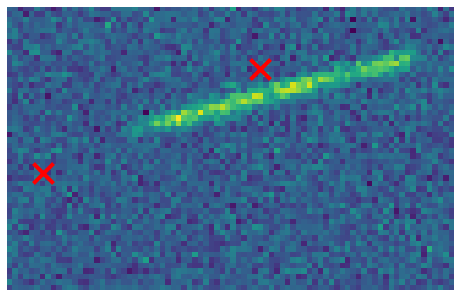

In [2]:
pixel_size = 110  # nm

# Open the image and its starting points for fitting
data_dir = Path('./')
fname = data_dir / "microtubule_0006_cropped.tif"

# Open the image
image = tifffile.imread(str(fname))

# Get microtubule tip coordinates
tip_start = np.array([40, 46])
tip_end = np.array([21, 6])

# Show initial seed
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image, interpolation='none', origin=[0, 0], cmap='viridis')
ax.set_aspect('equal')
ax.scatter(tip_start[1], tip_start[0], color='red', s=400, marker="x", linewidth=4)
ax.scatter(tip_end[1], tip_end[0], color='red', s=400, marker="x", linewidth=4)
#ax.plot([tip_end[1], tip_start[1]], [tip_end[0], tip_start[0]], color='red', linewidth=4, alpha=0.4)
ax.grid(False); ax.set_xticks([]); ax.set_yticks([]); ax.set_axis_off()
fig.savefig("step_1.png", bbox_inches='tight', pad_inches=0, dpi=400)

In [65]:
# Define fitting parameters
args = {}

args['get_thick_line_args'] = {}
args['get_thick_line_args']['length_spacing'] = 1  # pixel
args['get_thick_line_args']['line_thickness'] = 2000 / pixel_size  # pixel
args['get_thick_line_args']['width_spacing'] = 1  # pixel

args['perpendicular_line_fit_args'] = {}
args['perpendicular_line_fit_args']['length_spacing'] = 0.1  # pixel
args['perpendicular_line_fit_args']['fit_threshold'] = 0.15
args['perpendicular_line_fit_args']['continuous_discard'] = False

args['offset_start'] = 3000 / pixel_size  # pixel
args['offset_end'] = 3000 / pixel_size  # pixel

args['tip_fit_args'] = {}
args['tip_fit_args']['length_spacing'] = 0.1  # pixel
args['tip_fit_args']['line_thickness'] = 400 / pixel_size  # pixel
args['tip_fit_args']['width_spacing'] = 0.1  # pixel

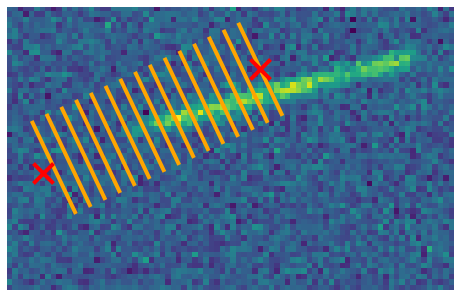

In [4]:
lines = anamic.fitter.get_thick_line(tip_start, tip_end, **args['get_thick_line_args'])

# Check the new points.
fig, ax = plt.subplots(figsize=(8, 8))

ax.imshow(image, interpolation='none', origin=[0, 0], cmap='viridis')
ax.set_aspect('equal')

for i in range(1, lines.shape[-1], 3):
    ax.plot(lines[1, :, i], lines[0, :, i], color='orange', marker="", lw=4)

#ax.plot(lines[1, :, 20], lines[0, :, 20], color='red', marker="", lw=4)

ax.scatter(tip_start[1], tip_start[0], color='red', s=400, marker="x", linewidth=4, zorder=999)
ax.scatter(tip_end[1], tip_end[0], color='red', s=400, marker="x", linewidth=4, zorder=999)

ax.grid(False); ax.set_xticks([]); ax.set_yticks([]); ax.set_axis_off()
fig.savefig("step_2.png", bbox_inches='tight', pad_inches=0, dpi=400)

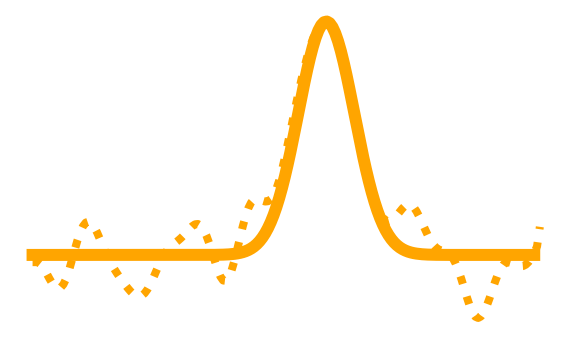

In [5]:
i = 20
line = lines[:, :, i]
point1 = line[:, 0]
point2 = line[:, -1]
x, y = anamic.fitter.line_profile(image, point1, point2)

mu = 10.48
sigma = 1
xf = np.arange(0, 18, 0.1)
yf = 0.25 * np.exp(-(xf - mu) ** 2 / (2 * (sigma ** 2))) + 0.75

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x, y, color='orange', lw=8, ls=':')
ax.plot(xf, yf, color='orange', lw=12)

ax.grid(False); ax.set_xticks([]); ax.set_yticks([]); ax.set_axis_off()
fig.savefig("step_2_2.png", bbox_inches='tight', pad_inches=0, dpi=400)

In [44]:
args['perpendicular_line_fit_args']['fit_threshold'] = 0.04
args['perpendicular_line_fit_args']['continuous_discard'] = False

fitted_line = anamic.fitter.perpendicular_line_fit(lines, image,
                                                   **args['perpendicular_line_fit_args'])

# Remove the last points in case it's a tapered tip.
fitted_line = fitted_line[:-2]

# Now we fit the best line from those points
a, b = np.polyfit(fitted_line[:, 1], fitted_line[:, 0], deg=1)
new_point1 = np.array([a * fitted_line[0, 1] + b, fitted_line[0, 1]])
new_point2 = np.array([a * fitted_line[-1, 1] + b, fitted_line[-1, 1]])

# This the new line defining the microtubule
new_line = np.array([new_point1, new_point2])

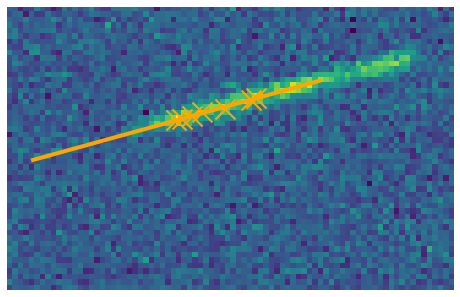

In [68]:
# Now we fit the microtubule using a line profile with a defined thickness.

# Calculate the vector of the line and its norm
vec = new_point2 - new_point1

# Get the coordinates of the points we'll use
# to for line fitting.
start_point = anamic.geometry.get_point_from_vector(-vec, new_point2, args['offset_start'])
end_point = anamic.geometry.get_point_from_vector(vec, new_point2, args['offset_end'])
line_fit_tips = np.array([start_point, end_point])

# Check the fitted points
fig, ax = plt.subplots(figsize=(8, 8))

ax.imshow(image, interpolation='none', origin=[0, 0], cmap='viridis')
ax.set_aspect('equal')

ax.scatter(fitted_line[:, 1], fitted_line[:, 0], color='orange', s=400, marker="x", linewidth=2, edgecolor='black')
ax.plot(line_fit_tips[:, 1], line_fit_tips[:, 0], color='orange', linewidth=4)

ax.grid(False); ax.set_xticks([]); ax.set_yticks([]); ax.set_axis_off()
fig.savefig("step_3.png", bbox_inches='tight', pad_inches=0, dpi=400)

In [69]:
x_profile, y_profile, fit_result, fit_func = anamic.fitter.tip_line_fit(line_fit_tips[0],
                                                                        line_fit_tips[1],
                                                                        image,
                                                                        **args['tip_fit_args'])
fit_values = fit_result.values
fit_values

{'mu': 32.470017593704625,
 'sigma': 3.4554041639073056,
 'mt': 0.17940866699428937,
 'bg': 0.7744486929514263}

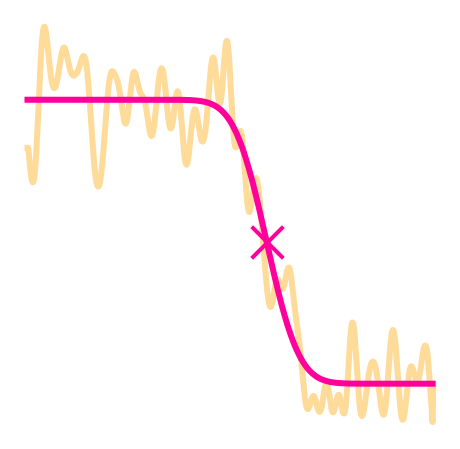

In [93]:
x = np.arange(x_profile[0], x_profile[-1], 0.1)
y_fitted = fit_func(x, **fit_values)

fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(x_profile, y_profile, label='data', lw=6, color="orange", alpha=0.4)
ax.plot(x, y_fitted, label='fit', lw=6, color="#ff009cff")

mu = fit_values['mu']
ax.scatter(mu, fit_func(mu, **fit_values), color='#ff009cff', s=1000, marker='x', zorder=999, lw=4)

ax.grid(False); ax.set_xticks([]); ax.set_yticks([]); ax.set_axis_off()
fig.savefig("step_4.png", bbox_inches='tight', pad_inches=0, dpi=400)

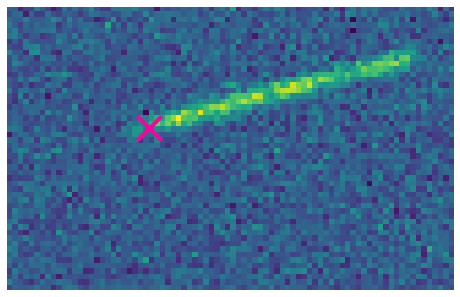

In [95]:
x = np.arange(x_profile[0], x_profile[-1], 0.1)
y_fitted = fit_func(x, **fit_values)

fig, ax = plt.subplots(figsize=(8, 8))

ax.imshow(image, interpolation='none', origin=[0, 0], cmap='viridis')
ax.set_aspect('equal')

tip_position = anamic.geometry.get_point_from_vector(vec, line_fit_tips[0], mu)
ax.scatter(tip_position[1], tip_position[0], color='#ff009cff', s=600, marker="x", lw=4)

ax.grid(False); ax.set_xticks([]); ax.set_yticks([]); ax.set_axis_off()
fig.savefig("step_5.png", bbox_inches='tight', pad_inches=0, dpi=400)